# Draw a global analysis by NOAA GFS using OPeNDAP

31-Dec-2020

2020年の年末は、12月29日 21UTC に[モンゴルで海面較正気圧が最高記録？の 1084 hPa になる](https://twitter.com/FPappenberger/status/1344318861659824129)？という、非常に強い寒気が形成されたことが[話題になりました](https://news.yahoo.co.jp/articles/c1dc42cc2bb7cebfe640f43eff655272c41e8f48?fbclid=IwAR1fJRafEohgT5kUtMFppF5sQl0obk0wsIJiYRKsrCjeI6rvnu3KWpuzLb0)。そこで、地表近くの気温を、NOAA の数値予報の解析値データで可視化してみます。

※ 以下は 2019年に鳥取大学乾燥地研究センターでの集中講義で使ったものを少し更新したもので、大元は NASA EarthObservatory の図 (https://earthobservatory.nasa.gov/images/144489/arctic-weather-plunges-into-north-america) を真似てみたものです。

この notebook では [OPeNDAP](https://www.opendap.org) で準リアルタイムの数値予報を公開している NOAA のサーバーから解析データ GDAS を取得して描画しています。地理情報描画には `cartopy` を、データ取得には多次元データライブラリ `xarray` を用いています (※ `xarray` の代わりに `netCDF4` でも同じことができます).

In [1]:
%matplotlib inline
import datetime as dt
import pytz
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

NOAA のウェブサイト https://nomads.ncep.noaa.gov では最新の数値予報データが提供されており、いくつかは OPeNDAP 形式で取得できます。

サイトを調べると、0.25°解像度の解析値 GDAS は次のような URL で OPeNDAP アクセスができることがわかります。
http://nomads.ncep.noaa.gov:80/dods/gdas_0p25/gdas20201230/gdas_0p25_18z

そのため、まず日付を指定して URL 文字列を作成します。

In [2]:
# 準リアルタイムデータ取得ならこんな風に
# d = dt.datetime.now(pytz.utc) - dt.timedelta(hours=9)  # 9-hour for a latency
# hr = int(d.hour / 6) * 6

d = dt.datetime(2020, 12, 29, 18, 0)    # hour は 0, 6, 12, 18 のいずれか
hr = d.hour
d

datetime.datetime(2020, 12, 29, 18, 0)

In [3]:
url = 'http://nomads.ncep.noaa.gov:80/dods/gdas_0p25/gdas{YMD}/gdas_0p25_{H:02}z'.format(YMD=d.strftime('%Y%m%d'),H=d.hour)
url

'http://nomads.ncep.noaa.gov:80/dods/gdas_0p25/gdas20201229/gdas_0p25_18z'

この URL から、`xarray` を用いてデータを取得します。 (GitHUB で表示すると冗長になるため、2行めはコメントアウトしています)

In [4]:
gdas_xr = xr.open_dataset(url)
# gdas_xr

C:\Users\taichu\miniconda3\envs\atmos_anaconda\lib\site-packages\xarray\coding\times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


地表面付近の気温の変数名は `tmp2m` なので、これを `cartopy` と `matplotlib` で可視化してみます。

Text(0.5, 1.0, 'GDAS 2-m temperature : 2020-12-29 21:00z')

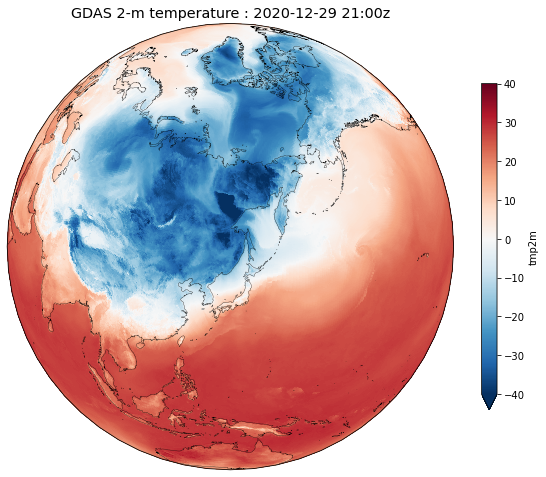

In [5]:
fig = plt.figure(figsize=(10.0, 10.0))
proj = ccrs.Orthographic(135.0, 50.0)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_global()
ax.coastlines(resolution='50m', linewidth=0.3)

t = 3
tmp2m = gdas_xr.tmp2m.isel(time=t) - 273.15

tmp2m.plot(ax=ax, cmap='RdBu_r', vmin=-40.0, vmax=40.0,
           transform=ccrs.PlateCarree(),
           cbar_kwargs={'shrink': 0.6})

ax.set_title(f'GDAS 2-m temperature : {gdas_xr.time[t].dt.strftime("%Y-%m-%d %H:%Mz").data}',
             fontsize='x-large')

画像として保存します。

In [6]:
fig.savefig('GDAS_tmp2m_{}.png'.format(gdas_xr.time[t].dt.strftime("%Y%m%d%H%M").data), dpi=300, bbox_inches='tight', pad_inches=0)